# LA Times

develop a model to predict post performance for new posts a user may want to create for this account.

In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import zipfile

In [2]:
%%time

with zipfile.ZipFile('posts.json.zip') as myzip:
    with myzip.open('posts.json') as f:
        lines = f.readlines()
        data = [json.loads(line) for line in lines]

CPU times: user 4.32 s, sys: 257 ms, total: 4.58 s
Wall time: 4.58 s


In [3]:
df = pd.DataFrame(data)

display(df.head())
display(df.shape)

,caption,created_time,description,feed_targeting,id,insights,link,link_to_post,message,name,picture,story
0,komonews.com,2015-09-17T20:50:00+0000,About 20 western Virginia high school students...,NaN,114431401958534_940695755998757,{'post_video_retention_graph_clicked_to_play':...,http://www.komonews.com/news/national/Students...,http://facebook.com/114431401958534_9406957559...,Do you think the Confederate flag should be ba...,Students suspended for clothing displaying Con...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN
1,NaN,2015-09-17T20:20:01+0000,NaN,NaN,114431401958534_940684872666512,{'post_negative_feedback_by_type_unique': {'ti...,https://www.facebook.com/KOMONews/photos/a.121...,http://facebook.com/114431401958534_9406848726...,Seattle Seahawks' Russell Wilson answered lots...,Timeline Photos,https://fbcdn-photos-b-a.akamaihd.net/hphotos-...,NaN
2,komonews.com,2015-09-17T19:49:28+0000,Despite September looking like it will break o...,NaN,114431401958534_940684229333243,{'post_video_retention_graph_clicked_to_play':...,http://www.komonews.com/weather/blogs/scott/Ne...,http://facebook.com/114431401958534_9406842293...,"It'll be a bummer for snow lovers, but warm-we...","New forecasts still say mild winter, hot summe...",https://external.xx.fbcdn.net/safe_image.php?d...,NaN
3,komonews.com,2015-09-17T19:18:00+0000,Amazon is dangling a $50 tablet computer in it...,NaN,114431401958534_940637569337909,{'post_video_retention_graph_clicked_to_play':...,http://www.komonews.com/news/tech/Amazon-dangl...,http://facebook.com/114431401958534_9406375693...,What do you think of Amazon's cheaper tablet?,Amazon dangles $50 tablet computer to hook mor...,https://fbexternal-a.akamaihd.net/safe_image.p...,NaN
4,komonews.com,2015-09-17T18:45:00+0000,Earth's record-breaking heat is sounding an aw...,NaN,114431401958534_940535546014778,{'post_video_retention_graph_clicked_to_play':...,http://www.komonews.com/news/national/Earths-r...,http://facebook.com/114431401958534_9405355460...,Meteorologists say 2015 is a near certainty to...,Earth's record streak of record heat keeps on ...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN


(8639, 12)

In [4]:
pd.DataFrame((df.isna().sum()/df.shape[0]).sort_values(), columns=['Null %'])

,Null %
created_time,0.000000
id,0.000000
insights,0.000000
link_to_post,0.000000
message,0.011691
link,0.062160
picture,0.067716
name,0.145619
caption,0.384883
description,0.470656


only created_time, id, insights, link_to_post, and actions are not missing anything

## What are insights?

Parse json data

In [5]:
%%time

dfs = [item[1] for item in df['insights'].iteritems()]

CPU times: user 3.92 ms, sys: 108 µs, total: 4.03 ms
Wall time: 4.09 ms


In [6]:
pd.DataFrame.from_dict(dfs[0])

,post_video_retention_graph_clicked_to_play,post_negative_feedback_by_type_unique,post_video_complete_views_paid_unique,post_video_complete_views_organic,post_video_views_unique,post_video_views_organic_unique,post_consumptions_by_type_unique,post_impressions_viral_unique,post_video_complete_views_30s_paid,post_negative_feedback_unique,...,post_fan_reach,post_stories_by_action_type,post_consumptions,post_story_adds_by_action_type,post_video_views_autoplayed,post_impressions_organic,post_impressions_by_story_type_unique,post_impressions_viral,post_video_complete_views_paid,post_video_complete_views_30s_autoplayed
description,Lifetime: Clicked-to-play views of your video ...,Lifetime: The number of people who have given ...,Lifetime: Number of times your video was viewe...,Lifetime: Number of times your video was viewe...,Lifetime: Number of unique people who viewed y...,Lifetime: Number of times your video was viewe...,Lifetime: The number of people who clicked any...,Lifetime: The number of people who saw your Pa...,Lifetime: Number of times your video was viewe...,Lifetime: The number of people who have given ...,...,Lifetime: The number of people who saw your Pa...,Lifetime: The number of stories created about ...,Lifetime: The number of clicks anywhere in you...,Lifetime: The number of stories created about ...,Lifetime: Number of times your video started a...,Lifetime: The number of impressions of your po...,Lifetime: The number of people who saw your Pa...,Lifetime: The number of impressions of your Pa...,Lifetime: Number of times your video was viewe...,Lifetime: Number of times your video started a...
id,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...,114431401958534_940695755998757/insights/post_...
name,post_video_retention_graph_clicked_to_play,post_negative_feedback_by_type_unique,post_video_complete_views_paid_unique,post_video_complete_views_organic,post_video_views_unique,post_video_views_organic_unique,post_consumptions_by_type_unique,post_impressions_viral_unique,post_video_complete_views_30s_paid,post_negative_feedback_unique,...,post_fan_reach,post_stories_by_action_type,post_consumptions,post_story_adds_by_action_type,post_video_views_autoplayed,post_impressions_organic,post_impressions_by_story_type_unique,post_impressions_viral,post_video_complete_views_paid,post_video_complete_views_30s_autoplayed
period,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,...,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime,lifetime
title,Lifetime Percentage of viewers clicked-to-play...,Lifetime Negative feedback,Lifetime Paid views to 95%,Lifetime Organic views to 95%,Lifetime Unique Video Views,Lifetime Organic Video Views,Lifetime Post consumers by type,Lifetime Post viral reach,Lifetime Paid 30-Second Views,Lifetime Negative feedback,...,Lifetime Post reach by people who like your Page,Lifetime Post Stories by action type,Lifetime Post Consumptions,Lifetime Post Stories by action type,Lifetime Auto-Played Video Views,Lifetime Post Organic Impressions,Lifetime 

In [7]:
pf = []
for d in dfs:
    pf.append(pd.DataFrame([[d[key]['id'].split('/')[0], d[key]['title'], 
                             d[key]['values'][0]['value']] for key in d.keys()]))

In [8]:
pf[0].head()

,0,1,2
0,114431401958534_940695755998757,Lifetime Percentage of viewers clicked-to-play...,{}
1,114431401958534_940695755998757,Lifetime Negative feedback,{'hide_clicks': 2}
2,114431401958534_940695755998757,Lifetime Paid views to 95%,0
3,114431401958534_940695755998757,Lifetime Organic views to 95%,0
4,114431401958534_940695755998757,Lifetime Unique Video Views,0


## Join this table with features

## TODO

- Handle nested variables

## Look at captions
- create feature for komonews

In [10]:
features =pd.get_dummies(df['caption'].fillna('').str.contains(r'komonews.com'), 
                         drop_first=True, prefix='komonnews')

## Parse Time

In [11]:
df['created_time'] = pd.to_datetime(df['created_time'])

## Create time features

In [12]:
weekday_name = df['created_time'].dt.weekday_name
month = df['created_time'].dt.month_name()

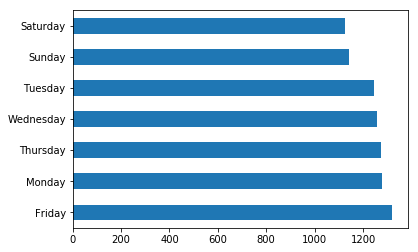

In [13]:
weekday_name.value_counts().plot.barh()

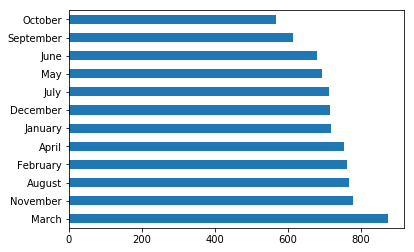

In [14]:
month.value_counts().plot.barh()

In [15]:
features = pd.concat([features, pd.get_dummies(weekday_name), pd.get_dummies(month)], 1)

In [20]:
features.head()

,komonnews_True,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## TODO with more time
- parse actions into appropriate data columns
- train using Logistic Regression, Random Forest, or Gradient Boosting
- validate using cross-validation
- test on new data, and evaluate performance